In [1]:
import numpy as np
import torch 
import torch.distributions as dist
import matplotlib.pyplot as plt
import random
from scipy.stats import norm 

## Simple example to show the effect of the flows and of the functions $f_i$ on the JMVAE loss

torch.Size([10000])


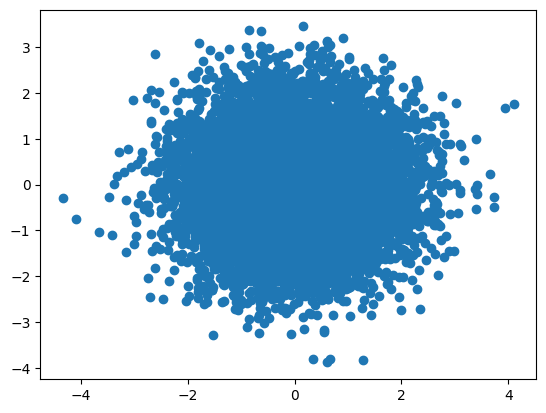

In [2]:
# Create an artificial dataset with a 2D latent space

# Fix the random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)



N = 10000
x = dist.Normal(0,1).sample([N])
y = dist.Normal(0,1).sample([N])
print(x.shape)
plt.scatter(x,y)
data=[x,y]

In [3]:
# We define the joint posterior to be a 2D gaussian with diagonal covariance matrix
s1 = 0.1
s2 = 0.1

def sample_from_joint_posterior(x,y,K=1):
    z1 = dist.Normal(x,s1).sample([K])
    z2 = dist.Normal(y,s2).sample([K])
    
    return torch.stack([z1, z2])

def sample_from_uni_posterior_x(x,K=1):
    z1 = dist.Normal(x,s1).sample([K])
    z2 = dist.Normal(0,np.sqrt(1+s2**2)).sample([K])
    
    return torch.stack([z1,z2])

def sample_from_uni_posterior_y(y,K=1):
    z1 = dist.Normal(0,np.sqrt(1+s1**2)).sample([K])
    z2 = dist.Normal(y,s2).sample([K])
    
    return torch.stack([z1,z2])

z1,z2 = sample_from_joint_posterior(x,y,K=100)
print(z1.shape)
    
    

torch.Size([100, 10000])


In [4]:
from torch import nn
from bivae.my_pythae.models.vae_maf import my_VAE_MAF, VAE_MAF_Config
from bivae.my_pythae.models.vae import my_VAE
from pythae.models.vae import VAEConfig
from pythae.models.nn.base_architectures import BaseDecoder, BaseEncoder
from pythae.models.base.base_utils import ModelOutput

n_hidden_dim = 100

class Encoder_VAE_MLP(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        layers = nn.ModuleList()

        layers.append(nn.Sequential(nn.Linear(np.prod(args.input_dim), n_hidden_dim), nn.ReLU()))

        self.layers = layers
        self.depth = len(layers)

        self.embedding = nn.Linear(n_hidden_dim, self.latent_dim)
        self.log_var = nn.Linear(n_hidden_dim, self.latent_dim)

    def forward(self, x, output_layer_levels = None):
        output = ModelOutput()

        max_depth = self.depth

        if output_layer_levels is not None:

            assert all(
                self.depth >= levels > 0 or levels == -1
                for levels in output_layer_levels
            ), (
                f"Cannot output layer deeper than depth ({self.depth}). "
                f"Got ({output_layer_levels})."
            )

            if -1 in output_layer_levels:
                max_depth = self.depth
            else:
                max_depth = max(output_layer_levels)

        out = x.reshape(-1, np.prod(self.input_dim))

        for i in range(max_depth):
            out = self.layers[i](out)

            if output_layer_levels is not None:
                if i + 1 in output_layer_levels:
                    output[f"embedding_layer_{i+1}"] = out
            if i + 1 == self.depth:
                output["embedding"] = self.embedding(out)
                output["log_covariance"] = self.log_var(out)

        return output
    
class Decoder_AE_MLP(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim

        # assert 0, np.prod(args.input_dim)

        layers = nn.ModuleList()

        layers.append(nn.Sequential(nn.Linear(args.latent_dim, n_hidden_dim), nn.ReLU()))

        layers.append(
            nn.Sequential(nn.Linear(n_hidden_dim, int(np.prod(args.input_dim))), nn.Sigmoid())
        )

        self.layers = layers
        self.depth = len(layers)

    def forward(self, z: torch.Tensor, output_layer_levels=None):

        output = ModelOutput()

        max_depth = self.depth

        if output_layer_levels is not None:

            assert all(
                self.depth >= levels > 0 or levels == -1
                for levels in output_layer_levels
            ), (
                f"Cannot output layer deeper than depth ({self.depth}). "
                f"Got ({output_layer_levels})."
            )

            if -1 in output_layer_levels:
                max_depth = self.depth
            else:
                max_depth = max(output_layer_levels)

        out = z

        for i in range(max_depth):
            out = self.layers[i](out)

            if output_layer_levels is not None:
                if i + 1 in output_layer_levels:
                    output[f"reconstruction_layer_{i+1}"] = out
            if i + 1 == self.depth:
                output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output

In [5]:




class my_model(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        vae = my_VAE_MAF
        vae_config = VAE_MAF_Config((1,1),latent_dim=2)
        e1,e2 = Encoder_VAE_MLP(vae_config), Encoder_VAE_MLP(vae_config)
        d1,d2 =Decoder_AE_MLP(vae_config), Decoder_AE_MLP(vae_config)
        self.vaes = nn.ModuleList([
            vae(model_config=vae_config, encoder=e1, decoder=d1),
            vae(model_config=vae_config, encoder=e2, decoder=d2)

        ])
        
    
    def compute_kld(self, data):
        """ Computes KL(q(z|x,y) || q(z|x)) + KL(q(z|x,y) || q(z|y))"""

        z_xy=sample_from_joint_posterior(data[0],data[1]).squeeze(1).permute(1,0)
        # print(z_xy.size())
        reg = 0
        details_reg = {}
        for m, vae in enumerate(self.vaes):
            # print(z_xy.shape)
            flow_output = vae.flow(z_xy) if hasattr(vae, "flow") else vae.inverse_flow(z_xy)
            vae_output = vae.encoder(data[m].unsqueeze(1))
            mu, log_var, z0 = vae_output.embedding, vae_output.log_covariance, flow_output.out
            log_q_z0 = (-0.5 * (log_var + np.log(2*np.pi) + torch.pow(z0 - mu, 2) / torch.exp(log_var))).sum(dim=1)

            # kld -= log_q_z0 + flow_output.log_abs_det_jac
            # details_reg[f'kld_{m}'] = qz_xy.sum() - (log_q_z0 + flow_output.log_abs_det_jac).sum()
            details_reg[f'kld_{m}'] =  - (log_q_z0 + flow_output.log_abs_det_jac).sum()

            reg += details_reg[f'kld_{m}']
            
        return reg, details_reg
    
    def sample_from_x(self, x, K=100):
        
        d = torch.stack([x]*K)
        z = self.vaes[0](d).z
        return z
    
    def sample_from_y(self, y, K=100):
        d = torch.stack([y]*K)
        z = self.vaes[1](d).z
        return z
    
    


In [7]:
# Now create a dataloader and train the flows

from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = my_model()
model.cuda()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-5, amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer,'min')

lr = []
losses = []


n_train = 9000
n_test = N - n_train
data_train = TensorDataset(x[:n_train], y[:n_train])
data_test = TensorDataset(x[n_train:], y[n_train:])
train_loader = DataLoader(data_train, 300)
test_loader = DataLoader(data_test, 300, shuffle=False)

best_test_loss = np.inf
for epoch in range(1000):
    train_loss = 0
    model.train()
    for data_ in train_loader:
        data_ = [d.cuda() for d in data_]
        loss,dict = model.compute_kld(data_)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    test_loss = 0
    model.eval()
    for data_ in test_loader:
        data_ = [d.cuda() for d in data_]
        with torch.no_grad():
            loss,dict = model.compute_kld(data_)
            test_loss += loss.item()
    if test_loss < best_test_loss:
        print('saved model')
        torch.save(model.state_dict(), 'model.pt')
        best_test_loss = test_loss  
    scheduler.step(test_loss)
    lr.append(optimizer.state_dict()['param_groups'][0]['lr'])
    losses.append(test_loss)
    print(f'Epoch {epoch} : train_loss {train_loss/len(data_train)}')
    print(f'Epoch {epoch} : test_loss {test_loss/len(data_test)}')



saved model
Epoch 0 : train_loss 6.962843451605902
Epoch 0 : test_loss 6.830992065429688
saved model
Epoch 1 : train_loss 6.791622884114584
Epoch 1 : test_loss 6.6606904296875
saved model
Epoch 2 : train_loss 6.611930962456597
Epoch 2 : test_loss 6.506016357421875
saved model
Epoch 3 : train_loss 6.463098931206598
Epoch 3 : test_loss 6.3498558349609375
saved model
Epoch 4 : train_loss 6.321701917860243
Epoch 4 : test_loss 6.228921264648437
saved model
Epoch 5 : train_loss 6.21149016655816
Epoch 5 : test_loss 6.145284484863281
saved model
Epoch 6 : train_loss 6.126471245659722
Epoch 6 : test_loss 6.041126037597656
saved model
Epoch 7 : train_loss 6.0501984320746525
Epoch 7 : test_loss 5.990611267089844
saved model
Epoch 8 : train_loss 5.996305460611979
Epoch 8 : test_loss 5.951221862792969
saved model
Epoch 9 : train_loss 5.967364759657118
Epoch 9 : test_loss 5.92538916015625
saved model
Epoch 10 : train_loss 5.936485039605035
Epoch 10 : test_loss 5.887101135253906
saved model
Epoch 11 

In [10]:
# Now create a dataloader and train the flows

from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = my_model()
model.cuda()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-5, amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer,'min')

lr = []
losses_no_scheduler = []


n_train = 9000
n_test = N - n_train
data_train = TensorDataset(x[:n_train], y[:n_train])
data_test = TensorDataset(x[n_train:], y[n_train:])
train_loader = DataLoader(data_train, 300)
test_loader = DataLoader(data_test, 300, shuffle=False)

best_test_loss = np.inf
for epoch in range(1000):
    train_loss = 0
    model.train()
    for data_ in train_loader:
        data_ = [d.cuda() for d in data_]
        loss,dict = model.compute_kld(data_)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    test_loss = 0
    model.eval()
    for data_ in test_loader:
        data_ = [d.cuda() for d in data_]
        with torch.no_grad():
            loss,dict = model.compute_kld(data_)
            test_loss += loss.item()
    if test_loss < best_test_loss:
        print('saved model')
        torch.save(model.state_dict(), 'model.pt')
        best_test_loss = test_loss  
    # scheduler.step(test_loss)
    lr.append(optimizer.state_dict()['param_groups'][0]['lr'])
    losses_no_scheduler.append(test_loss)
    print(f'Epoch {epoch} : train_loss {train_loss/len(data_train)}')
    print(f'Epoch {epoch} : test_loss {test_loss/len(data_test)}')



saved model
Epoch 0 : train_loss 6.962843451605902
Epoch 0 : test_loss 6.830992065429688
saved model
Epoch 1 : train_loss 6.791622884114584
Epoch 1 : test_loss 6.6606904296875
saved model
Epoch 2 : train_loss 6.611930962456597
Epoch 2 : test_loss 6.506016357421875
saved model
Epoch 3 : train_loss 6.463098931206598
Epoch 3 : test_loss 6.3498558349609375
saved model
Epoch 4 : train_loss 6.321701917860243
Epoch 4 : test_loss 6.228921264648437
saved model
Epoch 5 : train_loss 6.21149016655816
Epoch 5 : test_loss 6.145284484863281
saved model
Epoch 6 : train_loss 6.126471245659722
Epoch 6 : test_loss 6.041126037597656
saved model
Epoch 7 : train_loss 6.0501984320746525
Epoch 7 : test_loss 5.990611267089844
saved model
Epoch 8 : train_loss 5.996305460611979
Epoch 8 : test_loss 5.951221862792969
saved model
Epoch 9 : train_loss 5.967364759657118
Epoch 9 : test_loss 5.92538916015625
saved model
Epoch 10 : train_loss 5.936485039605035
Epoch 10 : test_loss 5.887101135253906
saved model
Epoch 11 

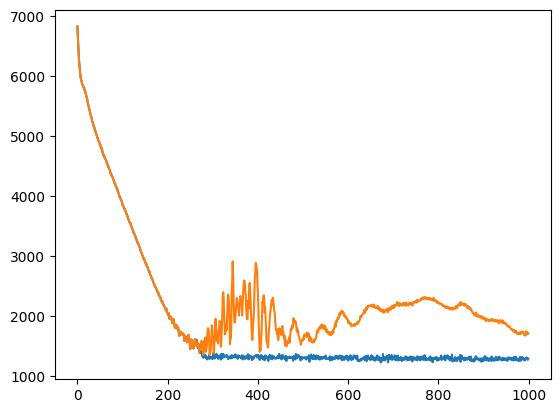

In [11]:
plt.plot(losses)
plt.plot(losses_no_scheduler)

In [ ]:
# Let's visualize the learned flows 

model = my_model()
model.load_state_dict(torch.load('model.pt'))
idx = 0
z_simulated_y = model.sample_from_y(y[idx], K = 500).detach().cpu()
z_simulated_x = model.sample_from_x(x[idx], K = 500).detach().cpu()

true_z_x = sample_from_uni_posterior_x(x[idx], K=500).detach().cpu()
true_z_y = sample_from_uni_posterior_y(y[idx], K=500).detach().cpu()
print(true_z_x.shape)

print(x[idx],y[idx])

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(z_simulated_x[:,0],z_simulated_x[:,1])
ax.scatter(z_simulated_y[:,0],z_simulated_y[:,1])

ax.scatter(true_z_x[0],true_z_x[1])
ax.scatter(true_z_y[0],true_z_y[1])

ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
